<a href="https://colab.research.google.com/github/cathyxinchangli/ATMS-597-SP-2020/blob/sarah/ATMS-597-SP-2020-Project-2/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
"""Weekly Averaged Temperature for NYC"""
# This code is part of a class assignment for ATMS 597, Spring 2020,
# at the University of Illinois at Urbana Champaign.
# Use this code to display weekly average temperature in NYC from
# 01/01/2018 to 01/01/2019 in a climate stripes graph.

import requests
import pandas as pd
import datetime
from IPython import display # for updating the cell dynamically
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import pandas as pd
import matplotlib.dates as mdates


def make_request(endpoint, payload=None):
    """
    Make a request to a specific endpoint on the weather API
    passing headers and optional payload.
    
    Parameters:
        - endpoint: The endpoint of the API you want to 
                    make a GET request to.
        - payload: A dictionary of data to pass along 
                   with the request.
    
    Returns:
        Response object.
    ---
    S. Moline, 'Hands on Data Analysis with Pandas'
    https://github.com/stefmolin/Hands-On-Data-Analysis-with-Pandas/blob/master/ch_04/0-weather_data_collection.ipynb
    """
    return requests.get(
        f'https://www.ncdc.noaa.gov/cdo-web/api/v2/{endpoint}',
        headers={
            'token': 'HfZphTTGbXckpmEuqevAXQZFRCTEJgkJ' # obtained by X. Li, 2/4/2020
        },
        params=payload
    )

# Set date range
current = datetime.date(2018, 1, 1)
end = datetime.date(2019, 1, 1)

results = []
while current < end:
    # Update the cell with status information
    display.clear_output(wait=True)
    display.display(f'Gathering data for {str(current)}')
    
    response = make_request(
        'data', 
        {
            'datasetid' : 'GHCND', # Global Historical Climatology Network - Daily (GHCND) dataset
            'datatypeid' : ['TMAX','TMIN'],
            'locationid' : 'CITY:US360019', # NYC
            'stationid' : 'GHCND:USC00280907',
            'startdate' : current,
            'enddate' : current,
            'units' : 'metric',
            'limit' : 1000 # max allowed
        })

    if response.ok:
        # We extend the list instead of appending to avoid getting a nested list
        results.extend(response.json()['results'])

    # Update the current date to avoid an infinite loop
    current += datetime.timedelta(days=1)

def clean_up(datain,key):
    '''
    TBD
    credit S. Nesbitt
    '''
    datain[key][(datain[key] == 9999)] = None
    datain[key]= datain[key].astype('float')
    return datain

'Gathering data for 2018-12-31'

In [0]:
# Create a dataframe to store the results
# Contains date, TMAX, TMIN, station, and value
df = pd.DataFrame(results)

In [4]:
# Clean up data for missing values (as represented by '9999' according to 
# GHCND documentation: https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf)
df = clean_up(df, 'value')
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df.index = df['date']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
# Resample to be weekly average:
df2 = df.resample('W').mean() #'W': weekly frequency

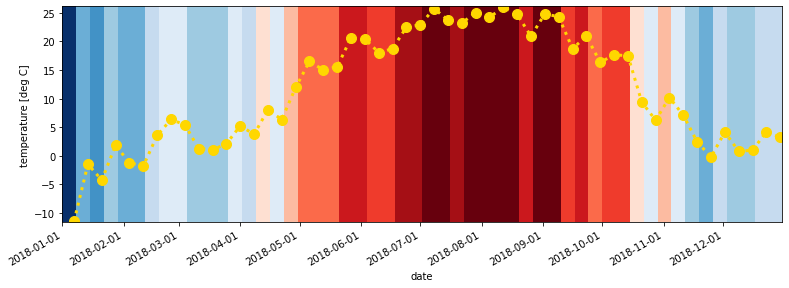

In [17]:
# Plotting
# copied from https://matplotlib.org/matplotblog/posts/warming-stripes/

# Time period
FIRST = datetime.date(2018, 1, 1)
LAST = datetime.date(2019, 1, 1)  # inclusive

# Reference period for the center of the color scale
FIRST_REFERENCE = datetime.date(2018, 3, 1)
LAST_REFERENCE = datetime.date(2018, 5, 1)

# Calculate anomaly
tavg = df2.loc[FIRST:LAST, 'value'].dropna() # average temperature
reference = tavg.loc[FIRST_REFERENCE:LAST_REFERENCE].mean() # reference temperature
LIM = tavg.quantile(q=0.95) # 95% quantile, degrees

# The colors in this colormap come from http://colorbrewer2.org
# The 8 more saturated colors from the 9 blues / 9 reds
cmap = ListedColormap([
    '#08306b', '#08519c', '#2171b5', '#4292c6',
    '#6baed6', '#9ecae1', '#c6dbef', '#deebf7',
    '#fee0d2', '#fcbba1', '#fc9272', '#fb6a4a',
    '#ef3b2c', '#cb181d', '#a50f15', '#67000d',
])

fig = plt.figure(figsize=(10, 3))

####### NEED TO MODIFY ######
ax = fig.add_axes([0, 0, 1, 1])
# ax.set_axis_off() # if user chooses to overlay data on top of the strips, we need the axes.
#############################

# Format dates for x-axis
date_str_list = ['{}'.format(d) for d in df['date'][0:len(df):2]]
date_corrected = mdates.datestr2num(date_str_list)

min_temp = df2.loc[:,'value'].min() # deg C
max_temp = df2.loc[:,'value'].max() # deg C
temp_delta = max_temp - min_temp # deg C
buffer = 0.2 # deg C

col = PatchCollection([
    Rectangle((y, min_temp-buffer), 7, temp_delta+2*buffer) # need to change 7 to other values when resampled at other frequencies
    for y in date_corrected.astype(int)[::7]
]) 

# set data, colormap and color limits
col.set_array(tavg)
col.set_cmap(cmap)
col.set_clim(min_temp, max_temp)
ax.add_collection(col)

ax.set_ylim(min_temp-buffer, max_temp+buffer)
ax.set_xlim(date_corrected[0], date_corrected[-1])
formatter = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(formatter)
fig.autofmt_xdate()

# flag needs to come into play here
ax.plot(df2['value'],':o',color='gold',linewidth=3, markersize=10)
ax.set_xlabel('date')
ax.set_ylabel('temperature [deg C]')

fig.savefig('warming-stripes.png')
fig.show()


In [12]:
min_temp = df2.loc[:,'value']
min_temp

date
2018-01-07   -11.392857
2018-01-14    -1.442857
2018-01-21    -4.242857
2018-01-28     1.857143
2018-02-04    -1.228571
2018-02-11    -1.742857
2018-02-18     3.564286
2018-02-25     6.357143
2018-03-04     5.435714
2018-03-11     1.264286
2018-03-18     1.071429
2018-03-25     2.114286
2018-04-01     5.250000
2018-04-08     3.771429
2018-04-15     8.057143
2018-04-22     6.350000
2018-04-29    11.950000
2018-05-06    16.500000
2018-05-13    15.028571
2018-05-20    15.557143
2018-05-27    20.628571
2018-06-03    20.442857
2018-06-10    18.064286
2018-06-17    18.714286
2018-06-24    22.492857
2018-07-01    22.892857
2018-07-08    25.750000
2018-07-15    23.728571
2018-07-22    23.221429
2018-07-29    25.021429
2018-08-05    24.214286
2018-08-12    25.957143
2018-08-19    24.728571
2018-08-26    20.907143
2018-09-02    24.835714
2018-09-09    24.300000
2018-09-16    18.735714
2018-09-23    20.914286
2018-09-30    16.335714
2018-10-07    17.664286
2018-10-14    17.500000
2018-10-21 